# Capstone Project: Age-Classfication Image Analysis

## 1. Problem Statement

Deep Learning is the foundation through which many breakthroughs are founded upon. One of it's biggest applications is in image anaylysis. Deep Learning has enabled many popular commercial features such as [Face ID](https://towardsdatascience.com/how-i-implemented-iphone-xs-faceid-using-deep-learning-in-python-d5dbaa128e1d) in the current iPhones, [portrait photography](https://ai.googleblog.com/2020/12/portrait-light-enhancing-portrait.html), and so on.

For this project, we will be looking into a simpler task: by using Deep Learning, we will train a model to identify the age of a person simply by analysing an image of their face.
This model can be applied to tackle many different tasks, such as:

- Sorting through a large collection of Family photos
- Analysing customer demographic of businesses (cafes/restaurants, tourist avenues)
- Health and Fitness tracking

## 2. Datasets

In order to train our model, we will need a large dataset of facial images that have been tagged with their respective ages. Thankfully, there exists a widely used dataset called [UTKFace](https://susanqq.github.io/UTKFace/), which is am extensive face dataset with images of people ranging from 1 to 116 years old. It consists of 20 0000 images, with their [corresponding details](https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv) of age, gender, and ethnicity noted as well.

## 3. Exploratory Data Analysis

We will first look through and analyse data to look for any missing/incomplete data points, as well as any outliers or imbalanced distributions

In [1]:
#Basic data analysis and coding imports

import pandas as pd
import numpy as np

import random
import os
import pathlib
import glob

In [2]:
#Imaging and data visualisation imports

import PIL.Image as Image
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#tensorflow imports for Deep Learning

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.python.keras.preprocessing import image

In [4]:
#Setting defaults for all data visualisation

font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)

In [5]:
data_url = 'https://www.dropbox.com/s/d0tzd4uh58iyb5k/age_gender.csv?dl=1'

In [6]:
data_dir = tf.keras.utils.get_file(origin=data_url, 
                                   fname='age_gender.csv')

data_dir = pathlib.Path(data_dir)

In [7]:
data_dir

PosixPath('/Users/ahmadzainichia/.keras/datasets/age_gender.csv')

In [8]:
face_data = pd.read_csv(data_dir)

In [9]:
face_data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [10]:
face_data.dtypes

age           int64
ethnicity     int64
gender        int64
img_name     object
pixels       object
dtype: object

In [11]:
face_data.shape

(23705, 5)

The CSV file gives us all the details of the images, including the pixels itself. 
We could use the pixels to reconstruct the images, but we first need to check the pixel values.

In [12]:
first_image = face_data['pixels'][0]
first_image = first_image.split()
first_image = [int(pixel) for pixel in first_image]
print(first_image)

[129, 128, 128, 126, 127, 130, 133, 135, 139, 142, 145, 149, 147, 145, 146, 147, 148, 149, 149, 150, 153, 153, 153, 152, 153, 153, 153, 153, 153, 151, 149, 147, 146, 146, 144, 143, 140, 134, 129, 129, 126, 122, 121, 119, 118, 118, 99, 53, 130, 129, 128, 126, 127, 130, 135, 141, 143, 143, 144, 145, 143, 142, 144, 145, 146, 149, 149, 148, 151, 151, 151, 151, 152, 153, 153, 153, 153, 149, 148, 147, 146, 146, 142, 141, 138, 133, 130, 130, 128, 123, 124, 122, 120, 117, 98, 52, 131, 129, 130, 129, 129, 134, 138, 144, 145, 143, 143, 139, 140, 138, 139, 140, 142, 145, 147, 149, 151, 149, 149, 149, 151, 152, 151, 150, 150, 148, 147, 145, 144, 142, 140, 137, 136, 135, 134, 131, 128, 126, 126, 123, 122, 114, 97, 50, 135, 134, 133, 132, 131, 136, 142, 145, 147, 144, 141, 143, 138, 131, 133, 134, 137, 139, 143, 147, 148, 149, 149, 149, 151, 151, 149, 147, 147, 146, 141, 139, 135, 137, 137, 137, 137, 138, 137, 134, 132, 129, 130, 124, 124, 115, 95, 52, 138, 139, 139, 135, 134, 138, 140, 140, 140, 14

In [13]:
len(first_image)

2304

In [14]:
2304**0.5

48.0

The pixels given in the CSV will only allow us to reconstruct a 48 X 48 grayscale image.   
The JPEG image files that were given in the UTK were 200 X 200 and in RGB format, which gives us more data for the model to train on.

Since we won't be using the pixel values given in the CSV file, we drop the column.

In [15]:
face_data.drop(columns = ['pixels'], inplace = True)

The labels of each face image is embedded in the file name, formated like (age) (gender) (race) (date&time).jpg

**Age**: integer from 1 to 116, indicating the age    
**Gender**: is either 0 (male) or 1 (female)      
**Race**: integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).    
**Date/Time**: shows the date and time an image was collected to UTKFace

For this project, we will only be looking at images of people aged 1 - 75.

In [16]:
face_data = face_data[face_data['age'] < 75]
face_data.head()

,age,ethnicity,gender,img_name
0,1,2,0,20161219203650636.jpg.chip.jpg
1,1,2,0,20161219222752047.jpg.chip.jpg
2,1,2,0,20161219222832191.jpg.chip.jpg
3,1,2,0,20161220144911423.jpg.chip.jpg
4,1,2,0,20161220144914327.jpg.chip.jpg


In [17]:
face_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,22706.0,31.107989,17.219179,1.0,23.0,28.0,41.0,74.0
ethnicity,22706.0,1.300361,1.352374,0.0,0.0,1.0,2.0,4.0
gender,22706.0,0.475469,0.499409,0.0,0.0,0.0,1.0,1.0


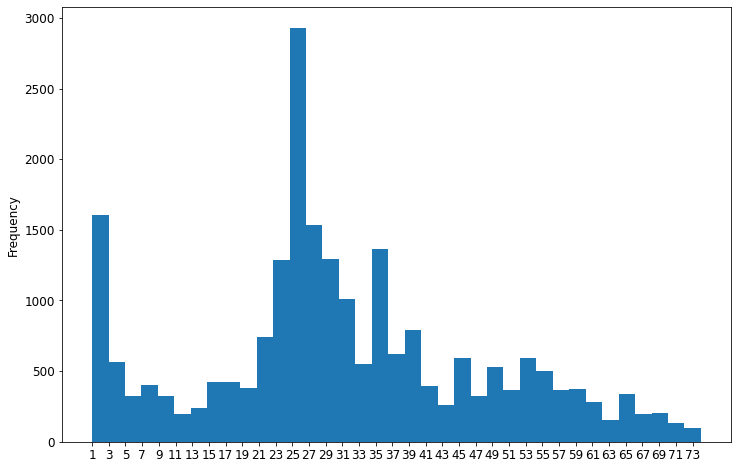

In [18]:
face_data['age'].plot(kind = 'hist', bins = 37, figsize = (12, 8))
plt.xticks(range(1, 75, 2))
plt.show()

<AxesSubplot:>

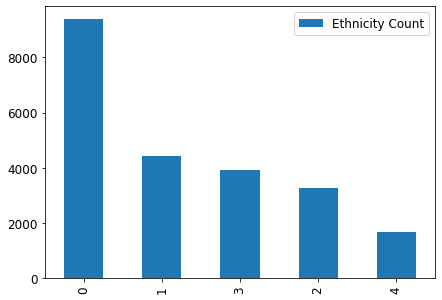

In [19]:
face_data['ethnicity'].value_counts().to_frame(name = "Ethnicity Count").plot(kind = 'bar', figsize = (7, 5))

In [20]:
face_data['ethnicity'].value_counts(normalize = True)

0    0.413283
1    0.194882
3    0.173302
2    0.144279
4    0.074254
Name: ethnicity, dtype: float64

<AxesSubplot:>

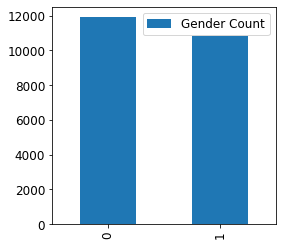

In [21]:
face_data['gender'].value_counts().to_frame(name = "Gender Count").plot(kind = 'bar', figsize = (4, 4))

**Imbalanced Data**

We can see that there is an imbalance in the ethnic profile of the images. 41% of the images are of White ethnicity, and only 7% of the images are in the 'Others' category (which includes Hispanic, Latino, Middle Eastern, etc).

There is also an imbalance in the age distribution: there is a large spike in ages 1-2 and 23-30.

### 3.1 Grouping up the Images

For this project, our approach for identifying age is through Classification. We will be grouping the images into discrete age groups, and then attempt to train the model to classify images correctly.

The age groups and age-ranges will be as follows:

- Baby:  1 
- Toddler:  2 - 3
- Child:  4 - 8
- Adolescent:  9 - 13
- Teen:  14 - 18
- Young Adult:  19 - 24
- Adult: 25 - 34
- Mature: 35 - 44
- Middle Age: 45 - 59
- Senior: 60 - 74

In [22]:
def age_classifier(age):
    
    if age == 1:
        
        age_group = 'Baby'
        
    elif age in range(2, 4):
        
        age_group = 'Toddler'
        
    elif age in range(4, 9):
        
        age_group = 'Child'
        
    elif age in range(9, 14):
        
        age_group = 'Adolescent'
        
    elif age in range(14, 19):
        
        age_group = 'Teenager'
        
    elif age in range(19, 25):
        
        age_group = 'Young Adult'
        
    elif age in range(25, 35):
        
        age_group = 'Adult'
        
    elif age in range(35, 45):
        
        age_group = 'Mature Adult'
        
    elif age in range(45, 59):
        
        age_group = 'Middle Age'
        
    else:
        
        age_group = 'Senior'
               
    return age_group

In [23]:
face_data['age group'] = face_data['age'].apply(age_classifier)

In [24]:
face_data[['age', 'age group']].sample(5)

#check whether function worked correctly

,age,age group
10631,3,Toddler
18772,52,Middle Age
15489,4,Child
22840,8,Child
8499,27,Adult


In [25]:
face_data['age group'].value_counts(normalize = True)

Adult           0.322558
Mature Adult    0.150929
Middle Age      0.144499
Young Adult     0.106051
Senior          0.077997
Baby            0.049458
Child           0.044129
Teenager        0.044085
Toddler         0.033956
Adolescent      0.026337
Name: age group, dtype: float64

<AxesSubplot:>

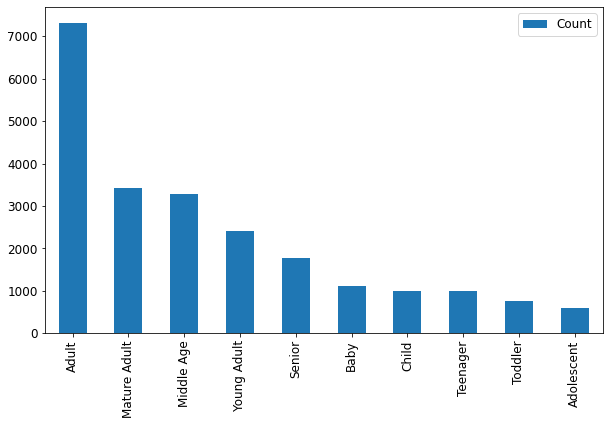

In [26]:
face_data['age group'].value_counts().to_frame(name = 'Count').plot(kind = 'bar', figsize = (10, 6))

In [27]:
face_data['age group'].value_counts(normalize = True)

Adult           0.322558
Mature Adult    0.150929
Middle Age      0.144499
Young Adult     0.106051
Senior          0.077997
Baby            0.049458
Child           0.044129
Teenager        0.044085
Toddler         0.033956
Adolescent      0.026337
Name: age group, dtype: float64

### 3.2 Data Cleaning

As we have found earlier, there are imbalances in the dataset. Specifically, the number of images in the age groups vary greatly: Adults form 32% of the images, while Adolescents take up only 2.6%. This is a difference of 12.3 times; more than an order of magnitude.

Ethnic distribution is very imbalanced as well, as pointed our earlier. We will try to reduce the imbalances in both areas.

In [28]:
#race: int from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

In [29]:
face_data[face_data['age group'] == 'Baby']['ethnicity'].value_counts()

2    430
0    287
3    234
4    139
1     33
Name: ethnicity, dtype: int64

In [30]:
drop_list = []

index = face_data[(face_data['age group'] == 'Baby') & (face_data['ethnicity'] == 2)].index
index = set(index)
    
drop_list.extend(random.sample(index, 50))

len(drop_list)

50

In [31]:
face_data.shape

(22706, 5)

In [32]:
face_data.drop(axis = 0, index = drop_list, inplace = True)
face_data.shape

(22656, 5)

In [33]:
face_data[face_data['age group'] == 'Baby']['ethnicity'].value_counts()

2    380
0    287
3    234
4    139
1     33
Name: ethnicity, dtype: int64

**Dropping images based on age group and ethnicity**

Depending on the numbers in each ethnic community for each age group, we will remove photos accordingly to reduce the imbalance.

In [34]:
face_data[face_data['age group'] == 'Toddler']['ethnicity'].value_counts()

2    298
0    209
4    122
3    107
1     35
Name: ethnicity, dtype: int64

In [35]:
face_data[face_data['age group'] == 'Child']['ethnicity'].value_counts()

0    479
2    187
3    144
4    118
1     74
Name: ethnicity, dtype: int64

In [36]:
drop_list = []

index = face_data[(face_data['age group'] == 'Child') & (face_data['ethnicity'] == 0)].index
index = set(index)
    
drop_list.extend(random.sample(index, 100))

len(drop_list)

100

In [37]:
face_data.shape

(22656, 5)

In [38]:
face_data.drop(axis = 0, index = drop_list, inplace = True)
face_data.shape

(22556, 5)

In [39]:
face_data[face_data['age group'] == 'Child']['ethnicity'].value_counts()

0    379
2    187
3    144
4    118
1     74
Name: ethnicity, dtype: int64

In [40]:
face_data[(face_data['age group'] == 'Adolescent')]['ethnicity'].value_counts()

0    424
4     48
1     44
2     42
3     40
Name: ethnicity, dtype: int64

In [41]:
drop_list = []

index = face_data[(face_data['age group'] == 'Adolescent') & (face_data['ethnicity'] == 0)].index
index = set(index)

drop_list.extend(random.sample(index, 150))

len(drop_list)

150

In [42]:
face_data.shape

(22556, 5)

In [43]:
face_data.drop(axis = 0, index = drop_list, inplace = True)
face_data.shape

(22406, 5)

In [44]:
face_data[face_data['age group'] == 'Adolescent']['ethnicity'].value_counts()

0    274
4     48
1     44
2     42
3     40
Name: ethnicity, dtype: int64

In [45]:
face_data[(face_data['age group'] == 'Teenager')]['ethnicity'].value_counts()

0    605
1    134
4    106
3     99
2     57
Name: ethnicity, dtype: int64

In [46]:
drop_list = []

index = face_data[(face_data['age group'] == 'Teenager') & (face_data['ethnicity'] == 0)].index
index = set(index)

drop_list.extend(random.sample(index, 250))

len(drop_list)

250

In [47]:
face_data.shape

(22406, 5)

In [48]:
face_data.drop(axis = 0, index = drop_list, inplace = True)
face_data.shape

(22156, 5)

In [49]:
face_data[face_data['age group'] == 'Teenager']['ethnicity'].value_counts()

0    355
1    134
4    106
3     99
2     57
Name: ethnicity, dtype: int64

In [50]:
face_data[(face_data['age group'] == 'Young Adult')]['ethnicity'].value_counts()

0    645
2    509
3    477
1    469
4    308
Name: ethnicity, dtype: int64

In [51]:
face_data[(face_data['age group'] == 'Adult')]['ethnicity'].value_counts()

0    2214
1    2052
3    1388
2    1147
4     523
Name: ethnicity, dtype: int64

In [52]:
drop_list = []

for i in range(2):
    
    index = face_data[(face_data['age group'] == 'Adult') & (face_data['ethnicity'] == i)].index
    index = set(index)
    
    drop_list.extend(random.sample(index, 1450))
    
index = face_data[(face_data['age group'] == 'Adult') & (face_data['ethnicity'] == 3)].index
index = set(index)

drop_list.extend(random.sample(index, 850))

index = face_data[(face_data['age group'] == 'Adult') & (face_data['ethnicity'] == 2)].index
index = set(index)

drop_list.extend(random.sample(index, 750))

index = face_data[(face_data['age group'] == 'Adult') & (face_data['ethnicity'] == 4)].index
index = set(index)
    
drop_list.extend(random.sample(index, 200))

In [53]:
len(drop_list)

4700

In [54]:
face_data.shape

(22156, 5)

In [55]:
face_data.drop(axis = 0, index = drop_list, inplace = True)
face_data.shape

(17456, 5)

In [56]:
face_data[face_data['age group'] == 'Adult']['ethnicity'].value_counts()

0    764
1    602
3    538
2    397
4    323
Name: ethnicity, dtype: int64

**Dropping images for Adult Age-group**

We drop images more aggresively for this age group because the overall numbers for adults still vastly outnumber the other age groups. We also try to reduce ethnicity imbalance.

In [57]:
face_data[face_data['age group'] == 'Mature Adult']['ethnicity'].value_counts()

0    1497
1     846
3     561
2     326
4     197
Name: ethnicity, dtype: int64

In [58]:
drop_list = []
    
index = face_data[(face_data['age group'] == 'Mature Adult') & (face_data['ethnicity'] == 3)].index
index = set(index)
    
drop_list.extend(random.sample(index, 150))

index = face_data[(face_data['age group'] == 'Mature Adult') & (face_data['ethnicity'] == 1)].index
index = set(index)
    
drop_list.extend(random.sample(index, 350))

index = face_data[(face_data['age group'] == 'Mature Adult') & (face_data['ethnicity'] == 0)].index
index = set(index)
    
drop_list.extend(random.sample(index, 900))
    
len(drop_list)

1400

In [59]:
face_data.shape

(17456, 5)

In [60]:
face_data.drop(axis = 0, index = drop_list, inplace = True)
face_data.shape

(16056, 5)

In [61]:
face_data[face_data['age group'] == 'Mature Adult']['ethnicity'].value_counts()

0    597
1    496
3    411
2    326
4    197
Name: ethnicity, dtype: int64

In [62]:
face_data[face_data['age group'] == 'Middle Age']['ethnicity'].value_counts()

0    1849
3     687
1     483
2     152
4     110
Name: ethnicity, dtype: int64

In [63]:
drop_list = []
    
index = face_data[(face_data['age group'] == 'Middle Age') & (face_data['ethnicity'] == 1)].index
index = set(index)
    
drop_list.extend(random.sample(index, 200))

index = face_data[(face_data['age group'] == 'Middle Age') & (face_data['ethnicity'] == 3)].index
index = set(index)
    
drop_list.extend(random.sample(index, 300))

index = face_data[(face_data['age group'] == 'Middle Age') & (face_data['ethnicity'] == 0)].index
index = set(index)
    
drop_list.extend(random.sample(index, 1400))
    
len(drop_list)

1900

In [64]:
face_data.shape

(16056, 5)

In [65]:
face_data.drop(axis = 0, index = drop_list, inplace = True)
face_data.shape

(14156, 5)

In [66]:
face_data[face_data['age group'] == 'Middle Age']['ethnicity'].value_counts()

0    449
3    387
1    283
2    152
4    110
Name: ethnicity, dtype: int64

In [67]:
face_data[face_data['age group'] == 'Senior']['ethnicity'].value_counts()

0    1175
1     255
3     198
2     128
4      15
Name: ethnicity, dtype: int64

In [68]:
drop_list = []

index = face_data[(face_data['age group'] == 'Senior') & (face_data['ethnicity'] == 0)].index
index = set(index)
    
drop_list.extend(random.sample(index, 800))
    
len(drop_list)

800

In [69]:
face_data.shape

(14156, 5)

In [70]:
face_data.drop(axis = 0, index = drop_list, inplace = True)
face_data.shape

(13356, 5)

In [71]:
face_data[face_data['age group'] == 'Senior']['ethnicity'].value_counts()

0    375
1    255
3    198
2    128
4     15
Name: ethnicity, dtype: int64

In [72]:
for age_group in face_data['age group'].unique(): 
    print(age_group)
    print(face_data[face_data['age group'] == age_group]['ethnicity'].value_counts())
    print(' ')

Baby
2    380
0    287
3    234
4    139
1     33
Name: ethnicity, dtype: int64
 
Adolescent
0    274
4     48
1     44
2     42
3     40
Name: ethnicity, dtype: int64
 
Teenager
0    355
1    134
4    106
3     99
2     57
Name: ethnicity, dtype: int64
 
Young Adult
0    645
2    509
3    477
1    469
4    308
Name: ethnicity, dtype: int64
 
Toddler
2    298
0    209
4    122
3    107
1     35
Name: ethnicity, dtype: int64
 
Adult
0    764
1    602
3    538
2    397
4    323
Name: ethnicity, dtype: int64
 
Mature Adult
0    597
1    496
3    411
2    326
4    197
Name: ethnicity, dtype: int64
 
Child
0    379
2    187
3    144
4    118
1     74
Name: ethnicity, dtype: int64
 
Middle Age
0    449
3    387
1    283
2    152
4    110
Name: ethnicity, dtype: int64
 
Senior
0    375
1    255
3    198
2    128
4     15
Name: ethnicity, dtype: int64
 


<AxesSubplot:>

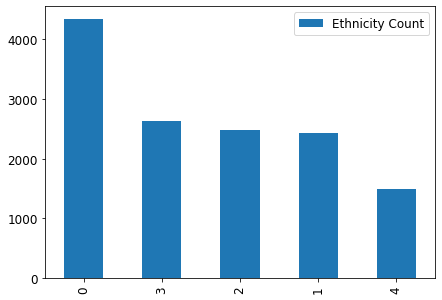

In [73]:
face_data['ethnicity'].value_counts().to_frame(name = "Ethnicity Count").plot(kind = 'bar', figsize = (7, 5))

In [74]:
face_data['ethnicity'].value_counts(normalize = True)

0    0.324498
3    0.197290
2    0.185385
1    0.181566
4    0.111261
Name: ethnicity, dtype: float64

<AxesSubplot:>

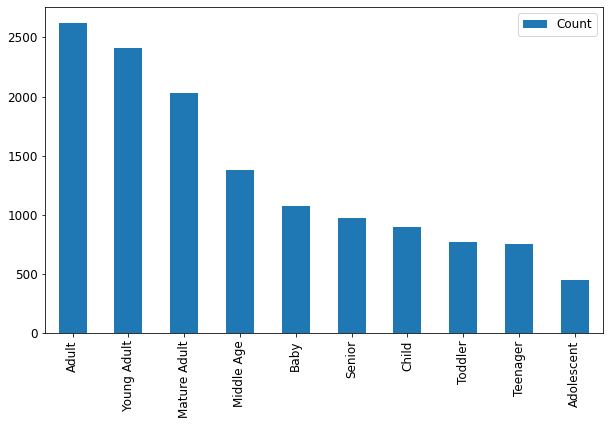

In [75]:
face_data['age group'].value_counts().to_frame(name = 'Count').plot(kind = 'bar', figsize = (10, 6))

In [76]:
face_data['age group'].value_counts(normalize = True)

Adult           0.196466
Young Adult     0.180294
Mature Adult    0.151767
Middle Age      0.103399
Baby            0.080338
Senior          0.072701
Child           0.067535
Toddler         0.057727
Teenager        0.056229
Adolescent      0.033543
Name: age group, dtype: float64

**Reduced Imbalance**

While the dataset is still not well-balanced, we have reduced the imbalance quite significantly. For example, now adults take up only 19.6% of the dataset, and Adolescents take up 3.3%. This is much improved compared to 32.2% and 2.6% previously.

### 3.3 Feature Engineering

While the image name is given in the CSV, the full filename is not given. However, we can construct the full filename from the other columns in the CSV.

Our age-groups will be our target-variable in our modelling later, but we will change it to ordinal labels for better evaluation.

In [77]:
face_data.reset_index(drop = True, inplace = True)

In [78]:
filenames = []

for i, row in face_data.iterrows():
        
    file = str(row[0]) + '_' + str(row[2]) + '_' + str(row[1]) + '_' + str(row[3])

    filenames.append(file)
        
len(filenames)

13356

In [79]:
face_data.shape

(13356, 5)

In [80]:
face_data['Filename'] = filenames

In [81]:
face_data.head()

,age,ethnicity,gender,img_name,age group,Filename
0,1,2,0,20161219203650636.jpg.chip.jpg,Baby,1_0_2_20161219203650636.jpg.chip.jpg
1,1,2,0,20161219222752047.jpg.chip.jpg,Baby,1_0_2_20161219222752047.jpg.chip.jpg
2,1,2,0,20161219222832191.jpg.chip.jpg,Baby,1_0_2_20161219222832191.jpg.chip.jpg
3,1,2,0,20161220144911423.jpg.chip.jpg,Baby,1_0_2_20161220144911423.jpg.chip.jpg
4,1,2,0,20161220144914327.jpg.chip.jpg,Baby,1_0_2_20161220144914327.jpg.chip.jpg


In [82]:
face_data.drop(columns = ['img_name'], inplace = True)

In [83]:
age_groups = ['Baby', 'Toddler', 'Child', 'Adolescent', 'Teenager',
              'Young Adult', 'Adult', 'Mature Adult', 'Middle Age', 'Senior']

In [84]:
age_groups.index('Toddler')

1

In [85]:
face_data['age group'].unique()

array(['Baby', 'Adolescent', 'Teenager', 'Young Adult', 'Toddler',
       'Adult', 'Mature Adult', 'Child', 'Middle Age', 'Senior'],
      dtype=object)

In [86]:
def age_labeler(age_group):
    
    label = age_groups.index(age_group)
    
    return label

In [87]:
face_data['age label'] = face_data['age group'].apply(age_labeler)

In [88]:
face_data.sample(5)

,age,ethnicity,gender,age group,Filename,age label
5022,24,1,1,Young Adult,24_1_1_20170115234919997.jpg.chip.jpg,5
2208,19,3,1,Young Adult,19_1_3_20170104223253815.jpg.chip.jpg,5
10210,44,1,0,Mature Adult,44_0_1_20170117142003663.jpg.chip.jpg,7
3675,22,0,1,Young Adult,22_1_0_20170112192301390.jpg.chip.jpg,5
10794,5,2,1,Child,5_1_2_20170109193543217.jpg.chip.jpg,2


In [89]:
face_data.to_csv('Data/age_gender_filtered.csv', index = False)